# Still No Buzz: Correction study of mispricing and inefficiency in online sportsbooks
## Predictive Analytics Project

Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import warnings

warnings.filterwarnings('ignore', 'SettingWithCopyWarning')
warnings.filterwarnings('ignore', category=FutureWarning)

from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf
from itertools import combinations

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

Loading Stata Data

In [2]:
df = pd.read_stata('final.dta')

#print(df.head())
print(df.columns.to_list)

<bound method IndexOpsMixin.tolist of Index(['hot_raw', 'year', 'hotness_l', 'lastname_l', 'hotness_w', 'lastname_w',
       'wta', 'location', 'tournament', 'tier', 'court', 'surface', 'round',
       'bestof', 'winner', 'loser', 'wrank', 'lrank', 'wpts', 'lpts', 'w1',
       'l1', 'w2', 'l2', 'w3', 'l3', 'wsets', 'lsets', 'comment', 'b365w',
       'b365l', 'exw', 'exl', 'lbw', 'lbl', 'psw', 'psl', 'sjw', 'sjl', 'maxw',
       'maxl', 'avgw', 'avgl', 'date', 'month', 'day', 'odds_player', 'player',
       'wiki_w', 'pid', 'wiki_med30_w', 'wiki_med365_w', 'wiki_med7_w',
       'wiki_mean30_w', 'wiki_mean365_w', 'wiki_mean7_w', 'wiki_min30_w',
       'wiki_min365_w', 'wiki_min7_w', 'wiki_mean_player_w',
       'wiki_med_player_w', 'wiki_yesterday_w', 'wiki_twodays_w', 'wiki_l',
       'wiki_med30_l', 'wiki_med365_l', 'wiki_med7_l', 'wiki_mean30_l',
       'wiki_mean365_l', 'wiki_mean7_l', 'wiki_min30_l', 'wiki_min365_l',
       'wiki_min7_l', 'wiki_mean_player_l', 'wiki_med_player_l',


2060845262.py:1: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  df = pd.read_stata('final.dta')


Fixing Variables

In [3]:
# RankDist Variable

def get_rankdist(winner_rank: int = 0, loser_rank: int = 0) -> float:
    if np.isnan(winner_rank): inverse_wr = 0
    else: inverse_wr = 1 / winner_rank
    if np.isnan(loser_rank): inverse_lr = 0
    else: inverse_lr = 1 / loser_rank
    rankdist = -(inverse_wr - inverse_lr)
    return rankdist

df['WRankDist'] = [get_rankdist(x,y) for x,y in zip(df['wrank'], df['lrank'])]
df['LRankDist'] = [get_rankdist(y, x) for x, y in zip(df['wrank'], df['lrank'])]

# WikiBuzz Variable

def get_wikibuzz(winner_pageviews, winner_median, loser_pageviews, loser_median):
    try: buzz = np.log(winner_pageviews / winner_median) - np.log(loser_pageviews / loser_median)
    except ZeroDivisionError: buzz = 'ZeroDivisionError'
    return buzz

df['W_WikiBuzz'] = [get_wikibuzz(row[0], row[1], row[2], row[3]) for row in zip(df['wiki_yesterday_w'], df['wiki_med365_w'],df['wiki_yesterday_l'], df['wiki_med365_l'])]
df['L_WikiBuzz'] = [get_wikibuzz(row[0], row[1], row[2], row[3]) for row in zip(df['wiki_yesterday_l'], df['wiki_med365_l'],df['wiki_yesterday_w'], df['wiki_med365_w'])]

# Inverse Odds

def impliedprob(player_odds): return 1/player_odds

df['W_inverse_bestodds'] = [impliedprob(x) for x in df['maxw']]
df['L_inverse_bestodds'] = [impliedprob(x) for x in df['maxl']]
df['W_inverse_avgodds'] = [impliedprob(x) for x in df['avgw']]
df['L_inverse_avgodds'] = [impliedprob(x) for x in df['avgl']]
df['W_inverse_B365'] = [impliedprob(x) for x in df['b365w']]
df['L_inverse_B365'] = [impliedprob(x) for x in df['b365l']]

# Date Column

df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

# Match index column

df['match_id'] = df.index

551752735.py:17: RuntimeWarning: divide by zero encountered in log
  try: buzz = np.log(winner_pageviews / winner_median) - np.log(loser_pageviews / loser_median)
551752735.py:17: RuntimeWarning: invalid value encountered in scalar subtract
  try: buzz = np.log(winner_pageviews / winner_median) - np.log(loser_pageviews / loser_median)
551752735.py:17: RuntimeWarning: divide by zero encountered in log
  try: buzz = np.log(winner_pageviews / winner_median) - np.log(loser_pageviews / loser_median)
551752735.py:17: RuntimeWarning: invalid value encountered in scalar subtract
  try: buzz = np.log(winner_pageviews / winner_median) - np.log(loser_pageviews / loser_median)


Extension of Cleaned DF - Preparing regressors for LASSO

In [ ]:
# Odds-Derived Features
df['b365_ratio'] = df['b365w'] / df['b365l']
df['avg_ratio'] = df['avgw'] / df['avgl']

# Wikipedia Trends
df['wiki_trend_diff_w'] = df['wiki_mean7_w'] - df['wiki_mean30_w']
df['wiki_trend_diff_l'] = df['wiki_mean7_l'] - df['wiki_mean30_l']
df['wiki_ratio'] = df['wiki_mean7_w'] / df['wiki_mean365_w']

# Elo-Derived Features
df['elo_diff'] = df['elo_pi_hat'] - df['elopredict']

# Margin of Victory: Set differences
df['set_diff'] = df['wsets'] - df['lsets']

# New Features for Extended Analysis
# Odds-Derived Features (extend further)
df['b365_margin'] = df['b365w'] - df['b365l']  # Margin between odds
df['avg_margin'] = df['avgw'] - df['avgl']     # Margin for average odds

# Wikipedia Trends
df['wiki_trend_ratio_w'] = df['wiki_mean7_w'] / (df['wiki_mean30_w'] + 1e-5)  # Ratio between short-term and mid-term
df['wiki_diff_yesterday_w'] = df['wiki_yesterday_w'] - df['wiki_mean7_w']    # Momentum change yesterday
df['wiki_mean_diff_w'] = df['wiki_mean30_w'] - df['wiki_mean365_w']          # Long-term performance trend

# Elo Features (additional insights)
df['elo_ratio'] = df['elo_pi_hat'] / (df['elopredict'] + 1e-5)               # Ratio of Elo prediction
df['elo_diff_squared'] = df['elo_diff'] ** 2                                # Non-linear effect of Elo differences

# Match Dynamics Features
df['game_diff'] = (df['w1'] + df['w2'] + df['w3']) - (df['l1'] + df['l2'] + df['l3'])  # Games won minus lost
df['total_games'] = (df['w1'] + df['w2'] + df['w3']) + (df['l1'] + df['l2'] + df['l3'])  # Total games played
df['game_win_rate'] = df['game_diff'] / (df['total_games'] + 1e-5)           # Proportion of games won

# Tournament-Specific Features
df['surface_encoded'] = df['surface'].factorize()[0]                        # Encode surface type as numeric
df['round_encoded'] = df['round'].factorize()[0]                            # Encode tournament round
df['bestof_encoded'] = df['bestof'].factorize()[0]                          # Encode best-of match format

# Long-Term Performance Trends
df['total_points_diff'] = df['wpts'] - df['lpts']                           # Points difference
df['points_ratio'] = df['wpts'] / (df['lpts'] + 1e-5)                       # Points ratio

# Split into winners and losers AFTER all computations
df_winners = df[['match_id', 'tournament', 'winner', 'date', 'year', 'WRankDist', 'W_WikiBuzz',
                 'W_inverse_B365', 'W_inverse_avgodds', 'W_inverse_bestodds', 
                 'b365_ratio', 'avg_ratio', 'wiki_trend_diff_w', 'elo_diff', 'set_diff',
                 'b365_margin', 'avg_margin', 'wiki_trend_ratio_w', 'wiki_diff_yesterday_w', 
                 'wiki_mean_diff_w', 'elo_ratio', 'elo_diff_squared', 'game_diff', 
                 'total_games', 'game_win_rate', 'surface_encoded', 'round_encoded', 
                 'bestof_encoded', 'total_points_diff', 'points_ratio']].copy()
df_winners['outcome'] = 1

df_losers = df[['match_id', 'tournament', 'loser', 'date', 'year', 'LRankDist', 'L_WikiBuzz',
                'L_inverse_B365', 'L_inverse_avgodds', 'L_inverse_bestodds', 
                'b365_ratio', 'avg_ratio', 'wiki_trend_diff_l', 'elo_diff', 'set_diff',
                'b365_margin', 'avg_margin', 'wiki_trend_ratio_w', 'wiki_diff_yesterday_w', 
                'wiki_mean_diff_w', 'elo_ratio', 'elo_diff_squared', 'game_diff', 
                'total_games', 'game_win_rate', 'surface_encoded', 'round_encoded', 
                'bestof_encoded', 'total_points_diff', 'points_ratio']].copy()
df_losers['outcome'] = 0

# Rename columns for consistency
df_winners.rename({'winner': 'player', 'WRankDist': 'rankdist', 'W_WikiBuzz': 'wikibuzz',
                   'W_inverse_B365': 'inverse_b365', 'W_inverse_avgodds': 'inverse_avg', 
                   'W_inverse_bestodds': 'inverse_best', 'wiki_trend_diff_w': 'wiki_trend_diff'}, 
                  axis=1, inplace=True)

df_losers.rename({'loser': 'player', 'LRankDist': 'rankdist', 'L_WikiBuzz': 'wikibuzz',
                  'L_inverse_B365': 'inverse_b365', 'L_inverse_avgodds': 'inverse_avg', 
                  'L_inverse_bestodds': 'inverse_best', 'wiki_trend_diff_l': 'wiki_trend_diff'}, 
                  axis=1, inplace=True)

# Reverse signs for losers
df_losers['b365_ratio'] = 1 / df_losers['b365_ratio']  # Inverse for losers
df_losers['elo_diff'] = -df_losers['elo_diff']
df_losers['set_diff'] = -df_losers['set_diff']
df_losers['b365_margin'] = -df_losers['b365_margin']
df_losers['avg_margin'] = -df_losers['avg_margin']
df_losers['wiki_trend_ratio_w'] = -df_losers['wiki_trend_ratio_w']
df_losers['elo_ratio'] = 1 / df_losers['elo_ratio']
df_losers['game_diff'] = -df_losers['game_diff']
df_losers['game_win_rate'] = -df_losers['game_win_rate']

# Combine winners and losers into a single DataFrame
df = pd.concat([df_winners, df_losers], axis=0)

# Function to compute streaks
def compute_streaks(player_df):
    streak = 0
    streaks = []
    last_outcome = None

    for outcome in player_df['outcome']:
        if outcome == last_outcome:
            streak += 1  # Continue streak
        else:
            streak = 1  # Reset streak
        streaks.append(streak)
        last_outcome = outcome

    return streaks

# Sort data by player and date to ensure chronological order
df.sort_values(by=['player', 'date'], inplace=True)

# Group by player and compute streaks
df['streak'] = (
    df.groupby('player', group_keys=False)
    .apply(lambda x: pd.Series(compute_streaks(x)))
    .reset_index(drop=True)  # Reset index to avoid duplicate labels
)

# Compute dynamic streaks considering game dynamics
df['dynamic_streak'] = (
    df.groupby('player', group_keys=False)
    .apply(lambda x: pd.Series(compute_streaks(x)))
    .reset_index(drop=True)
)

In [5]:
# Remove bad rows.
df = df.loc[df["wikibuzz"] != np.inf]
df = df.loc[df["wikibuzz"] != -np.inf]
df = df.loc[df["wikibuzz"] != 'ZeroDivisionError']

# Drop bad rows if necessary (similar to your wikibuzz cleaning step)
df = df[df['wikibuzz'].notna()]
df = df[df['rankdist'].notna()]
df = df[df['inverse_avg'].notna()]
df = df[df['elo_diff'].notna()]
df = df[df['set_diff'].notna()]

# Sort by date to maintain sequence
df.sort_values(by='date', inplace=True)

In [6]:
# Link players to their Wikipedia pages.
url = "https://drive.google.com/file/d/1PP6qoLuh43Fdkj5oVfqTKN4TWe6dcwfd/view?usp=share_link"
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
players = pd.read_csv(path)

player_dict = dict(zip(players.odds_player, players.player))
new_player_dict = {
    'Pliskova_Ka.':'Karolína_Plíšková',
    'Williams_S.':'Serena_Williams',
    'Pliskova_Kr.':'Kristýna_Plíšková',
    'Alexandra_Krunic':'Aleksandra_Krunić',
    'Yingying_Duan':'Duan_Yingying',
    'Lin_Zhu':'Zhu_Lin_(tennis)',
    'Rodionova_Ar.':'Arina_Rodionova',
    'Carina_Witthoeft':'Carina_Witthöft',
    'Stefanie_Voegele':'Stefanie_Vögele',
    'Sílvia_Soler-Espinosa':'Sílvia_Soler_Espinosa',
    'Xinyun_Han':'Han_Xinyun',
    'Yafan_Wang':'Wang_Yafan',
    'Jana_Cepelova':'Jana_Čepelová',
    'Zhang_Shuai':'Zhang_Shuai',
    'Catherine_McNally':'Caty_McNally',
    'Viktoria_Kuzmova':'Viktória_Kužmová',
    'Barbora_Krejcikova':'Barbora_Krejčíková',
    'En-Shuo_Liang':'Liang_En-shuo',
    'Chloe_Paquet':'Chloé_Paquet',
    'Su-Wei_Hsieh':'Hsieh_Su-wei',
    'Saisai_Zheng':'Zheng_Saisai',
    'Marketa_Vondrousova':'Markéta_Vondroušová',
    'Fangzhou_Liu':'Liu_Fangzhou',
    'Patricia_Maria_Tig':'Patricia_Maria_Țig',
    'Julia_Goerges':'Julia_Görges',
    'Lesley_Pattinama_Kerkhove':'Lesley_Pattinama_Kerkhove',
    'Tamara_Zidansek':'Tamara_Zidanšek',
    'Iga_Swiatek':'Iga_Świątek',
    'Anna_Karolina_Schmiedlova':'Anna_Karolína_Schmiedlová',
    'Shuai_Peng':'Peng_Shuai',
    'Leonie_Kung':'Leonie_Küng',
    'Radwanska_U.':'Agnieszka_Radwańska',
    'Barbora_Strycova':'Barbora_Strýcová',
    'Cagla_Buyukakcay':'Çağla_Büyükakçay',
    'Rodionova_An.':'Arina_Rodionova',
    'Alexandra_Cadantu':'Alexandra_Cadanțu-Ignatik',
    'Marie_Bouzkova':'Marie_Bouzková',
    'Denisa_Allertova':'Denisa_Šátralová',
    'Lucie_Hradecka':'Lucie_Hradecká',
    'Ivana_Jorovic':'Ivana_Jorović',
    'Maia_Lumsden':'Maia_Lumsden',
    'Mirjana_Lucic':'Mirjana_Lučić-Baroni',
    'Hailey_Baptiste':'Hailey_Baptiste',
    'Katerina_Siniakova':'Kateřina_Siniaková',
    'Mihaela_Buzarnescu':'Mihaela_Buzărnescu',
    'Qiang_Wang':'Wang_Qiang_(tennis)',
    'Xiaodi_You':'You_Xiaodi',
    'Paula_Cristina_Goncalves':'Paula_Cristina_Gonçalves',
    'Aliona_Bolsova':'Aliona_Bolsova',
    'Tereza_Smitkova':'Tereza_Smitková',
    'Xinyu_Wang':'Wang_Xinyu',
    'Leylah_Fernandez':'Leylah_Fernandez',
    'Magdalena_Rybarikova':'Magdaléna_Rybáriková',
    'Johanna_Larsson':'Johanna_Larsson',
    'Mirjana_Lucic-Baroni':'Mirjana_Lučić-Baroni',
    'Danka_Kovinic':'Danka_Kovinić',
    'Tereza_Martincova':'Tereza_Martincová',
    'Montserrat_Gonzalez':'Montserrat_González',
    'Maria_Herazo_Gonzalez':'María_Herazo_González',
    'Ipek_Soylu':'İpek_Soylu',
    'Petra_Martic':'Petra_Martić',
    'Timea_Babos':'Tímea_Babos',
    'Nina_Stojanovic':'Nina_Stojanović',
    'Na-Lae_Han':'Han_Na-lae',
    'Jia-Jing_Lu':'Lu_Jiajing', #From 2nd iteration, losers column...
    'Lesley_Pattinama_Kerkhove':'Lesley_Pattinama_Kerkhove',
    'Ya-Hsuan_Lee':'Lee_Ya-hsuan',
    'Alexandra_Cadanțu-Ignatik':'Alexandra_Cadanțu-Ignatik',
    'Maria_Mateas':'Maria_Mateas',
    'Selena_Janicijevic':'Séléna_Janicijevic',
    'Jessica_Pieri':'Jessica_Pieri',
    'Denisa_Šátralová':'Denisa_Šátralová',
    'Kamilla_Rakhimova':'Kamilla_Rakhimova',
    'Tess_Sugnaux':'Tess_Sugnaux',
    'Maia_Lumsden':'Maia_Lumsden',
    'Mirjam_Bjorklund':'Mirjam_Björklund',
    'Alyssa_Mayo':'Alyssa_Mayo',
    'Komola_Umarova':'Komola_Umarova',
    'Ng_Kwan-yau':'Ng_Kwan-yau',
    'Cristiana_Ferrando':'Cristiana_Ferrando',
    'Martina_Capurro_Taborda':'Martina_Capurro_Taborda',
    'Elena-Gabriela_Ruse':'Elena-Gabriela_Ruse',
    'Freya_Christie':'Freya_Christie',
    'Jovana_Jovic':'Jovana_Jović',
    'Mira_Antonitsch':'Mira_Antonitsch',
    'Dayana_Yastremska':'Dayana_Yastremska',
    'Emiliana_Arango':'Emiliana_Arango',
    'Nadia_Echeverria_Alam':'Nadia_Echeverría_Alam',
    'Frances_Altick':'Frances_Altick',
    'Ayaka_Okuno':'Ayaka_Okuno',
    'Anastasiya_Shoshyna':'Anastasiya_Shoshyna',
    'Jesika_Maleckova':'Jesika_Malečková',
    'Wushuang_Zheng':'Zheng_Wushuang',
    'Karolina_Muchova':'Karolína_Muchová',
    'Varvara_Gracheva':'Varvara_Gracheva',
    'Baindl_K.':'Kateryna_Baindl', # third iteration here
    'Uchijima_M.':'Moyuka_Uchijima',
    'Kalieva_E.':'Elvina_Kalieva',
    'Osorio_M.':'Camila_Osorio',
    'Naito_Y.':'Yuki_Naito',
    'Lazaro_A.':'Andrea_Lázaro_García',
    'Alves_C.':'Carolina_Alves_(tennis)',
    'Schunk_N.':'Nastasja_Schunk',
    'Saigo_R.':'Rina_Saigo',
    'Ioana_Minca':'Ioana_Mincă',
    'Zheng_Q.':'Zheng_Qinwen',
    'Guth_M.':'Mara_Guth',
    'Palicova_B.':'Barbora_Palicová',
    'Shibahara_E.':'Ena_Shibahara',
    'Pliskova_Ka.':'Karolína_Plíšková',
    'Reyngold_E.':'Ekaterina_Reyngold',
    'Middendorf_J.':'Julia_Middendorf',
    'Cengiz_B.':'Berfu_Cengiz',
    'Jeong_B.':'Jeong_Bo-young',
    'Szabanin_N.':'Natália_Szabanin',
    'Stakusic_M.':'Marina_Stakusic',
    'Mandlik_E.':'Elizabeth_Mandlik',
    'Contreras_Gomez_F.':'Fernanda_Contreras_Gómez',
    'Paoletti_M.':'Matilde_Paoletti',
    'Lamens_S.':'Suzan_Lamens',
    'Sherif_M.':'Mayar_Sherif',
    'Alexandra_Krunic':'Aleksandra_Krunić',
    'Bartunkova_N.':'Nikola_Bartůňková',
    'Jones_F.':'Francesca_Jones_(tennis)',
    'Yashina_E.':'Ekaterina_Yashina',
    'Mariana_Duque-Mariño':'Mariana_Duque_Mariño',
    'Bassols_Ribera_M.':'Marina_Bassols_Ribera',
    'Fruhvirtova_L.':'Linda_Fruhvirtová',
    'Laura_Pous-Tio':'Laura_Pous_Tió',
    'Williams_S.':'Serena_Williams',
    'Serban_R.':'Raluca_Șerban',
    'Caregaro_M.':'Martina_Caregaro',
    'Gabueva_A.':'Angelina_Gabueva',
    'Stearns_P.':'Peyton_Stearns',
    'Na-Lae_Han':'Han_Na-lae',
    'Scott_K.':'Katrina_Scott',
    'Lovric_P.':'Pia_Lovrič',
    'Bandecchi_S.':'Susan_Bandecchi',
    'Preston_T.':'Taylah_Preston',
    'Bronzetti_L.':'Lucia_Bronzetti',
    'Berberovic_N.':'Nefisa_Berberović',
    'Herazo_M.':'María_Herazo_González',
    'Montgomery_R.':'Robin_Montgomery',
    'Turati_B.':'Bianca_Turati',
    'Hewitt_D.':'Dalayna_Hewitt',
    'Hanatani_N.':'Nagi_Hanatani',
    'Zueger_J.':'Joanne_Züger',
    'Noskova_L.':'Linda_Nosková',
    'Marcinko_P.':'Petra_Marčinko',
    'Kraus_S.':'Sinja_Kraus',
    'Chang_S.':'Sophie_Chang',
    'Yu_E.':'Eleana_Yu',
    'Krawczyk_D.':'Desirae_Krawczyk',
    'Krueger_A.':'Ashlyn_Krueger',
    'Prisacariu_A.':'Andreea_Prisăcariu',
    'Jimenez_V.':'Victoria_Jiménez_Kasintseva',
    'En-Shuo_Liang':'Liang_En-shuo',
    'Monnet_C.':'Carole_Monnet',
    'Radivojevic_L.':'Lola_Radivojević',
    'Ruse_E-G.':'Elena-Gabriela_Ruse',
    'Morderger_Y.':'Yana_Morderger',
    'Burillo_I.':'Irene_Burillo_Escorihuela',
    'Sebov_K.':'Katherine_Sebov',
    'Mansouri_Y.':'Yasmine_Mansouri',
    'Bejlek_S.':'Sára_Bejlek',
    'Jang_S.':'Jang_Su-jeong',
    'Wurth_T.':'Tara_Würth',
    'Yingying_Duan':'Duan_Yingying',
    'Pigato_L.':'Lisa_Pigato',
    'Back_D.':'Back_Da-yeon',
    'Glushko_L.':'Lina_Glushko',
    'Kartal_S.':'Sonay_Kartal',
    'Andreeva_E.':'Erika_Andreeva',
    'Ignatik_A.':'Alexandra_Cadanțu-Ignatik',
    'Bassols_M.':'Marina_Bassols_Ribera',
    'Cross_K.':'Kayla_Cross',
    'Yifan_Xu':'Xu_Yifan',
    'Maria_Camila_Osorio_Serrano':'Camila_Osorio',
    'Anderson_R.':'Robin_Anderson_(tennis)',
    'Radisic_N.':'Nika_Radišić',
    'Parrizas_Diaz_N.':'Nuria_Párrizas_Díaz',
    'Sun_L.':'Lulu_Sun',
    'Sakatsume_H.':'Himeno_Sakatsume',
    'Bucsa_C.':'Cristina_Bucșa',
    'Jacquemot_E.':'Elsa_Jacquemot',
    'Bektas_E.':'Emina_Bektas',
    'María-Teresa_Torró-Flor':'María_Teresa_Torró_Flor',
    'Yang_Zha.':'Yang_Zhaoxuan',
    'Nuudi_M.':'Maileen_Nuudi',
    'Okamura_K.':'Kyōka_Okamura',
    'Falkowska_W.':'Weronika_Falkowska',
    'Talaba_G.':'Gabriela_Lee',
    'Kulambayeva_Z.':'Zhibek_Kulambayeva',
    'Fruhvirtova_B.':'Linda_Fruhvirtová',
    'Falkner_Z.':'Živa_Falkner',
    'Harrison_Ca.':'Catherine_Harrison_(tennis)',
    'Brace_C.':'Cadence_Brace',
    'Radwanska_U.':'Agnieszka_Radwańska',
    'Eala_A.':'Alex_Eala',
    'Plazas_J.':'Jessica_Plazas',
    'Grey_S.':'Sarah_Beth_Grey',
    'Gervais_J.':'Julie_Gervais',
    'Raducanu_E.':'Emma_Raducanu',
    'Carle_M.':'María_Carlé',
    'Tjandramulia_O.':'Olivia_Tjandramulia',
    'Di_Sarra_F.':'Federica_Di_Sarra',
    'Olyanovskaya_V.':'Valeriia_Olianovskaia',
    'Kubka_M.':'Martyna_Kubka',
    'McNally_C.':'Caty_McNally',
    'Natalija_Kostic':'Natalija_Stevanović',
    'Baszak_W.':'Weronika_Baszak',
    'Papamichail_D.':'Despina_Papamichail',
    'Bhatia_R.':'Riya_Bhatia',
    'Chwalinska_M.':'Maja_Chwalińska',
    'Havlickova_L.':'Lucie_Havlíčková',
    'Hartono_A.':'Arianne_Hartono',
    'Hontama_M.':'Mai_Hontama',
    'Gleason_Q.':'Quinn_Gleason',
    'Burrage_J.':'Jodie_Burrage',
    'Hatouka_Y.':'Yuliya_Hatouka',
    'Pliskova_Kr.':'Kristýna_Plíšková',
    'Lys_E.':'Eva_Lys',
    'Gadecki_O.':'Olivia_Gadecki',
    'Rodionova_Ar.':'Arina_Rodionova',
    'Lee_G.':'Gabriela_Lee',
    'Malygina_E.':'Elena_Malõgina',
    'Stefanini_L.':'Lucrezia_Stefanini',
    'Sutjiadi_A.':'Aldila_Sutjiadi',
    'Jeanjean_L.':'Léolia_Jeanjean',
    'Miyazaki_Y.':'Yuriko_Miyazaki',
    'Maria_Herazo_Gonzalez':'María_Herazo_González',
    'Tkacheva_M.':'Mariia_Tkacheva',
    'Mendez_S.':'Seone_Mendez',
    'Rodionova_An.':'Arina_Rodionova',
    'Saville_D.':'Daria_Saville',
    'Mishina_D.':'Daria_Mishina',
    'Andreea_Rosca':'Andreea_Roșca',
    'Babel_O.':'Océane_Babel',
    'Ji-Hee_Choi':'Choi_Ji-hee',
    'Anshba_A.':'Amina_Anshba',
    'Brancaccio_N.':'Nuria_Brancaccio',
    'Shymanovich_I.':'Iryna_Shymanovich',
    'Mboko_V.':'Victoria_Mboko',
    'Zakharova_A.':'Maria_Zakharova',
    'Riske-Amritraj_A.':'Alison_Riske-Amritraj',
    'Gasanova_A.':'Anastasia_Gasanova',
    'Selekhmeteva_O.':'Oksana_Selekhmeteva',
    'Wagner_S.':'Stephanie_Wagner',
    'Tikhonova_A.':'Anastasia_Tikhonova_(tennis)',
    'Da_Silva_Fick_G.':'Gabriella_Da_Silva-Fick',
    'Jani_R-L.':'Réka_Luca_Jani',
    'Avanesyan_E.':'Elina_Avanesyan',
    'Silva_E.':'Eden_Silva',
    'Monroy_Y.':'Yuliana_Monroy',
    'Raducànu_E.':'Emma_Raducanu',
    'Zuger_J.':'Joanne_Züger',
    'Andreeva_M.':'Erika_Andreeva',
    'Salkova_D.':'Dominika_Šalková',
    'Parks_A.':'Alycia_Parks',
    'Snigur_D.':'Daria_Snigur'
} # Introduce new player:wikipedia_page dictionary.
player_dict = player_dict | new_player_dict

df.replace({'player': player_dict}, inplace=True)

In [7]:
print(df.head())
print(df['streak'].max())

      match_id              tournament            player       date    year  \
1376      1376  Brisbane International  Eugenie Bouchard 2017-01-01  2017.0   
1371      1371             ASB Classic       Kurumi Nara 2017-01-01  2017.0   
1376      1376  Brisbane International     Shelby Rogers 2017-01-01  2017.0   
1371      1371             ASB Classic   Antonia Lottner 2017-01-01  2017.0   
1378      1378           Shenzhen Open   Evgeniya Rodina 2017-01-01  2017.0   

      rankdist  wikibuzz  inverse_b365  inverse_avg  inverse_best  ...  \
1376 -0.004790 -0.963591      0.694444     0.662252      0.636943  ...   
1371 -0.007602 -1.810834      0.769231     0.757576      0.735294  ...   
1376  0.004790  0.963591      0.381679     0.396825      0.369004  ...   
1371  0.007602  1.810834      0.294118     0.302115      0.277778  ...   
1378  0.002320 -0.906721      0.526316     0.505051      0.454545  ...   

      total_games  game_win_rate  surface_encoded  round_encoded  \
1376        

In [8]:
df.to_csv("data_clean.csv")

Loading the Data

In [9]:



original_df = pd.read_csv("data_clean.csv", index_col=0)
original_df.reset_index(inplace=True, drop=True)

print(original_df)
print(original_df['date'])

print(original_df.columns)

       match_id              tournament                 player        date  \
0          1376  Brisbane International       Eugenie Bouchard  2017-01-01   
1          1371             ASB Classic            Kurumi Nara  2017-01-01   
2          1376  Brisbane International          Shelby Rogers  2017-01-01   
3          1371             ASB Classic        Antonia Lottner  2017-01-01   
4          1378           Shenzhen Open        Evgeniya Rodina  2017-01-01   
...         ...                     ...                    ...         ...   
12193      4142           Ladies Trophy          Maria Sakkari  2020-02-15   
12194      4139           Ladies Trophy  Ekaterina Alexandrova  2020-02-15   
12195      4141           Thailand Open     Patricia Maria Tig  2020-02-15   
12196      4143           Ladies Trophy         Elena Rybakina  2020-02-16   
12197      4143           Ladies Trophy           Kiki Bertens  2020-02-16   

         year  rankdist  wikibuzz  inverse_b365  inverse_avg  i

Transforming the Data

In [10]:
# Assuming 'original_df' is your DataFrame with the original data
original_df['error'] = 0

# Encoding categorical 'tournament' column
original_df['tournament'] = original_df['tournament'].astype('category').cat.codes

# Combine 'tournament' and 'year' into a single column and encode it
original_df['tournament_and_year'] = original_df['year'].astype(str) + '_' + original_df['tournament'].astype(str)
original_df['tournament_and_year'] = original_df['tournament_and_year'].astype('category').cat.codes

# Calculate the overrounds
original_df['overround_b365'] = original_df.groupby('match_id')['inverse_b365'].transform(lambda x: x.sum(min_count=1) - 1)
original_df['overround_avg'] = original_df.groupby('match_id')['inverse_avg'].transform(lambda x: x.sum(min_count=1) - 1)
original_df['overround_best'] = original_df.groupby('match_id')['inverse_best'].transform(lambda x: x.sum(min_count=1) - 1)

# Set the 'error' column based on outcome
original_df.loc[original_df['outcome'] == 1, 'error'] = 1 - original_df['inverse_avg']
original_df.loc[original_df['outcome'] != 1, 'error'] = 0 - original_df['inverse_avg']

# Split into train and test sets
trainset = original_df[original_df['year'] < 2019]
testset = original_df[original_df['year'] >= 2019]

# Reset index for test set
testset.reset_index(inplace=True)

print('Train set rows: ' + str(len(trainset)))
print('Test set rows: ' + str(len(testset)))


Train set rows: 7836
Test set rows: 4362


Highlighting the erroneous row - Note how inverse_b365 < inverse_best when it should be greater than or equal to. This is removed from the data frames we use.

This was also performed by the authors

In [11]:
testset[(testset['match_id'] == 5883) & (testset['player'] == 'Polona Hercog')]

,index,match_id,tournament,player,date,year,rankdist,wikibuzz,inverse_b365,inverse_avg,...,total_points_diff,points_ratio,outcome,streak,dynamic_streak,error,tournament_and_year,overround_b365,overround_avg,overround_best
986,8822,5883,61,Polona Hercog,2019-03-23,2019.0,-0.001824,-1.707411,0.181818,0.540541,...,121.0,1.21492,1,1,1,0.459459,159,0.059011,0.03559,-0.101869


In [12]:
# Remove Hercog bet from both of the data frames we will use
testset_no_hercog = testset.drop(testset[(testset['match_id'] == 5883) & (testset['player'] == 'Polona Hercog')].index)
original_df.drop(original_df[(original_df['match_id'] == 5883) & (original_df['player'] == 'Polona Hercog')].index, inplace=True)

Replicating results

In [13]:
# Select regression by setting rankdist and wikibuzz True or False.
# For models PM, PM w/o RD (aka. WB), RD, MO.
def fit_regression(train_set, rankdist: bool = True, wikibuzz: bool = True):
    if wikibuzz and rankdist:
        formula = 'outcome ~ inverse_avg + rankdist + wikibuzz' # params = [constant, inverse_avg, rankdist, wikibuzz]
    elif wikibuzz and not rankdist:
        formula = 'outcome ~ inverse_avg + wikibuzz' # params = [constant, inverse_avg, wikibuzz]
    elif rankdist and not wikibuzz:
        formula = 'outcome ~ inverse_avg + rankdist' # params = [constant, inverse_avg, rankdist]
    else:
        formula = 'outcome ~ inverse_avg' # params = [constant, inverse_avg]
    results = smf.ols(formula, data=train_set).fit(cov_type='cluster', cov_kwds={'groups': trainset['match_id']})
    params = results.params
    return params


def simple_probability(params: pd.Series,
                         inverse_odds: float):
    y_hat = params[0] + params[1]*inverse_odds
    return y_hat

# Returns model's estimated probability.
def estimate_probability(params: pd.Series,
                         inverse_odds: float,
                         rankdist: float = None,
                         wikibuzz: float = None) -> float:
    y_hat = params[0] + params[1]*inverse_odds
    if (rankdist is not None) & (wikibuzz is not None):
        y_hat += params[-2]*rankdist + params[-1]*wikibuzz
    if (rankdist is not None) & (wikibuzz is None):
        y_hat += params[-1] * rankdist
    if (wikibuzz is not None) & (rankdist is None):
        y_hat += params[-1] * wikibuzz
    return y_hat

# Determine Kelly stake
def kelly_criterion(odds_implied_prob, y_hat):
    odds = 1/odds_implied_prob
    return max(y_hat - ((1 - y_hat)/(odds - 1)), 0)

# Calculate Profit/Loss
def profit_loss(kelly, odds_implied_prob, outcome):
    return kelly * (outcome / odds_implied_prob - 1)

# Estimates probability according to model selection, creates new columns, and prints results
def show_results(testset, params, odds, estimated_probabilities, rankdist: bool = True, wikibuzz: bool = True): # Odds = "avg", "best", "b365"
    # Estimate Probability
    testset[estimated_probabilities] = testset.apply(lambda row: estimate_probability(params,
                                                                                 inverse_odds=row['inverse_avg'],
                                                                                 rankdist=row['rankdist'] if rankdist else None,
                                                                                 wikibuzz=row['wikibuzz'] if wikibuzz else None),axis=1)
    # Determine kelly bet size
    testset.loc[:, 'kelly_betsize'] = [kelly_criterion(row[0], row[1]) for row in zip(testset['inverse_{}'.format(odds)], testset[estimated_probabilities])]
    # Calculate return for the bet.
    testset.loc[:, 'PnL'] = [profit_loss(row[0], row[1], row[2]) for row in zip(testset['kelly_betsize'],testset['inverse_{}'.format(odds)], testset['outcome'])]

    # Print Statistics
    inverse_odds_col = f'inverse_{odds}'
    overround_col = f'overround_{odds}'

    bets_considered = len(testset[testset[inverse_odds_col].notna()])
    bets_placed = len(testset.loc[(testset["PnL"].notna()) & (testset["PnL"] != 0)])
    mean_overround = testset[testset[overround_col] != 0][overround_col].mean() * 100
    absolute_bet_amount = testset['kelly_betsize'].sum()
    absolute_return = testset['PnL'].sum()
    roi = (((absolute_return + absolute_bet_amount) / absolute_bet_amount) - 1) * 100

    print(f'''
    Bets considered (2 * Matches): {bets_considered}
    Number of bets placed: {bets_placed}
    Mean overround (%): {mean_overround:.3f}
    Absolute amount bet: {absolute_bet_amount:.2f}
    Absolute return: {absolute_return:.2f}
    ROI (%): {roi:.2f}
    ''')
    return testset

# PnL plot
def plot_results(primary_data, compare_data=None):
    fig, ax = plt.subplots(figsize=(6, 6))

    # Convert 'date' columns to datetime objects
    primary_data['date'] = pd.to_datetime(primary_data['date'])
    primary_data['Cum_PnL'] = primary_data['PnL'].cumsum() * 100
    max_value = primary_data['Cum_PnL'].max()
    if compare_data is not None:
        compare_data['date'] = pd.to_datetime(compare_data['date'])
        compare_data['Cum_PnL'] = compare_data['PnL'].cumsum() * 100
        compare_data.plot('date', 'Cum_PnL', ax=ax, linewidth=2.5, label='Without Hercog bet')
        primary_data.plot('date', 'Cum_PnL', ax=ax, linewidth=2.5, label='With Hercog bet', linestyle='--', color='black')
        max_value = max(max_value, compare_data['Cum_PnL'].max())
    else:
        primary_data.plot('date', 'Cum_PnL', ax=ax, linewidth=2.5, label='Cumulative PnL', linestyle='--', color='black')
    ax.set_ylabel('Absolute Return (%)')
    ax.set_xlabel('Date')
    ax.legend(fancybox=False, shadow=False, frameon=True, facecolor='white', framealpha=1)

    # Quarterly x-axis
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10)))
    
    def custom_formatter(x, pos):
        month = mdates.num2date(x).month
        quarter = (month-1)//3 + 1
        year = mdates.num2date(x).year
        return f"Q{quarter} {year}"

    ax.xaxis.set_major_formatter(FuncFormatter(custom_formatter))
    fig.autofmt_xdate()

    plt.rcParams.update({'font.size': 14})
    if max_value > 200:
        ax.set_ylim(-50, 400)
    else:
        ax.set_ylim(-100, 200)
    plt.axhline(y=0, color='grey', linewidth=2.5)
    
    ax.set_facecolor('white')  # Set the background color of the plot to white
    fig.patch.set_facecolor('white') 
    ax.grid(True, which='both', color='grey', linestyle='-', linewidth=0.5)
    plt.show()

# Estimates probability according to model selection, creates new columns, and prints results - WITH CUMULATIVE KELLY
def correct_kelly_results(odds, rankdist: bool = True, wikibuzz: bool = True): # Odds = "avg", "best", "b365"
    
    params = fit_regression(rankdist=rankdist,wikibuzz=wikibuzz)
    show_results(testset, params, odds, rankdist=rankdist, wikibuzz=wikibuzz)
    
    testset['bankroll_after'] = testset['PnL'] + 1
    testset['bankroll_after'] = testset['bankroll_after'].cumprod()
    testset['bankroll_before'] = testset.bankroll_after.shift(1)
    testset['betsize_of_inital_bankroll'] = testset['kelly_betsize'] * testset['bankroll_before']
    testset['pnl_of_initial_bankroll'] = testset['PnL'] * testset['bankroll_before']
    print("---------------")
    print("*Correct Kelly*")
    print('Bets considered (2 * Matches): '+str(len(testset[testset['inverse_{}'.format(odds)].notna()])))
    print('Number of bets placed: '+str(len(testset.loc[(testset["PnL"].notna()) & testset["PnL"] != 0])))
    #print("Mean overround (%): "+str((testset.sort_values(by="match_id")["inverse_{}".format(odds)].rolling(2).sum()[1::2].mean()-1)*100))
    print("Mean overround (%): "+str(testset[testset['overround_{}'.format(odds)] != 0]['overround_{}'.format(odds)].mean()*100))
    print('Absolute amount bet: ' + str(testset['betsize_of_inital_bankroll'].sum()))
    print('Absolute return: ' + str(testset['pnl_of_initial_bankroll'].sum()))
    print('ROI (%): ' + str((((testset['pnl_of_initial_bankroll'].sum() + testset['betsize_of_inital_bankroll'].sum()) / testset[
    'betsize_of_inital_bankroll'].sum()) - 1)*100))
    
# PnL plot - WITH CUMULATIVE KELLY
def correct_kelly_plot_results():
    testset["Cum_PnL"] = (testset["bankroll_after"] -1) * 100
    plt.rcParams.update({'font.size': 8}) # 16
    fig, ax = plt.subplots(1, 1, figsize=(3, 3)) # 6, 6
    testset.plot('date', 'Cum_PnL', ax=ax, linewidth=1.25) # 2.5
    ax.set_ylabel('Absolute Return (%)')
    ax.set_xlabel('Date')
    ax.get_legend().remove()
    fig.autofmt_xdate()
    ax.set_ylim(-100, 200)
    plt.axhline(y=0, color='grey').set_linewidth(2.5)
    plt.show()


from linearmodels import IV2SLS
BOLD = '\033[1m'
END = '\033[0m'
# PM
mod = IV2SLS.from_formula('error ~ inverse_avg + rankdist + wikibuzz + C(year)', trainset)
resid = mod.fit(cov_type='clustered', clusters=trainset[['tournament_and_year', 'match_id']])
print(f"{BOLD}Preferred Model summary:{END}\n", resid)
# PM w/o RD
mod = IV2SLS.from_formula('error ~ inverse_avg + wikibuzz + C(year)', trainset)
resid = mod.fit(cov_type='clustered', clusters=trainset[['tournament_and_year', 'match_id']])
print(f"{BOLD}\nPreferred Model without RankDist variable summary:{END}\n", resid)

Preferred Model summary:
                             OLS Estimation Summary                            
Dep. Variable:                  error   R-squared:                      0.0010
Estimator:                        OLS   Adj. R-squared:                 0.0005
No. Observations:                7836   F-statistic:                    57.702
Date:                Mon, Dec 02 2024   P-value (F-stat)                0.0000
Time:                        12:13:04   Distribution:                  chi2(4)
Cov. Estimator:             clustered                                         
                                                                              
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept            -0.0561     0.0233    -2.4112     0.0159     -0.1017     -0.010

New Functions

In [15]:
# Select regression by setting rankdist and wikibuzz True or False.
# For models PM, PM w/o RD (aka. WB), RD, MO.
def fit_regression(train_set, regressors):
    """
    Fit a regression model with dynamic regressors.

    Parameters:
    - train_set: Training dataset (DataFrame)
    - regressors: List of regressor names

    Returns:
    - Fitted model parameters
    """
    # Ensure 'outcome' is included in the dataset
    if 'outcome' not in train_set.columns:
        raise ValueError("Column 'outcome' must be in the training dataset.")
    
    # Generate the formula dynamically
    formula = 'outcome ~ ' + ' + '.join(regressors)
    
    # Fit the regression model
    model = smf.ols(formula=formula, data=train_set).fit(cov_type='cluster', cov_kwds={'groups': train_set['match_id']})
    
    return model.params




def preprocess_data(data, categorical_vars):
    """
    Preprocess data by converting categorical variables into dummy variables.

    Parameters:
    - data: The DataFrame to preprocess
    - categorical_vars: List of column names to treat as categorical variables

    Returns:
    - The modified DataFrame
    """
    data = data.copy()
    for cat_var in categorical_vars:
        # Ensure categorical variable has clean values
        if data[cat_var].dtype in [float, int]:
            data[cat_var] = data[cat_var].astype(int)
        data[cat_var] = data[cat_var].astype(str).str.strip()

        # Create dummy variables
        dummies = pd.get_dummies(data[cat_var], prefix=cat_var, drop_first=True)

        # Sanitize dummy variable names
        dummies.columns = [col.replace(" ", "_").replace(".", "_") for col in dummies.columns]

        data = pd.concat([data, dummies], axis=1)
    return data




def simple_probability(params: pd.Series,
                         inverse_odds: float):
    y_hat = params[0] + params[1]*inverse_odds
    return y_hat

# Returns model's estimated probability.
def estimate_probability(params: pd.Series, row: pd.Series, regressors: list) -> float:
    """
    Estimate the probability of outcome using the model's parameters and given regressors.

    Parameters:
    - params: Fitted parameters from the regression
    - row: A single row of the dataset
    - regressors: List of regressors used in the model

    Returns:
    - Estimated probability
    """
    # Start with the intercept
    y_hat = params[0]
    
    # Add contributions from all specified regressors
    for i, regressor in enumerate(regressors, start=1):
        if regressor in row.index:  # Check to avoid KeyError
            y_hat += params[i] * row[regressor]
    
    return y_hat



# Determine Kelly stake
def kelly_criterion(odds_implied_prob, y_hat):
    odds = 1/odds_implied_prob
    return max(y_hat - ((1 - y_hat)/(odds - 1)), 0)

# Calculate Profit/Loss
def profit_loss(kelly, odds_implied_prob, outcome):
    return kelly * (outcome / odds_implied_prob - 1)

# Estimates probability according to model selection, creates new columns, and prints results
def show_results(testset, params, odds, estimated_probabilities, regressors):
    """
    Evaluate model results and compute PnL dynamically with regressors.

    Parameters:
    - testset: Test dataset (DataFrame)
    - params: Model parameters (Series)
    - odds: Type of odds used for evaluation (e.g., "avg", "best")
    - estimated_probabilities: Name of the column to store estimated probabilities
    - regressors: List of regressors used in the model
    """
    def estimate_probability_row(row):
        y_hat = params[0]  # Intercept
        for idx, regressor in enumerate(regressors):
            # Check if the regressor exists in the dataset
            if regressor in row.index:
                y_hat += params[idx + 1] * row[regressor]
            else:
                print(f"Warning: Regressor '{regressor}' not found in the testset!")
        return y_hat

    # Debug: Print parameter details
    print("Model Parameters:")
    print(params)
    print("\nRegressors Used:")
    print(regressors)

    # Calculate estimated probabilities
    testset[estimated_probabilities] = testset.apply(estimate_probability_row, axis=1)

    # Calculate Kelly bet size
    testset['kelly_betsize'] = testset.apply(
        lambda row: kelly_criterion(row[f'inverse_{odds}'], row[estimated_probabilities]), axis=1
    )

    # Compute Profit/Loss (PnL)
    testset['PnL'] = testset.apply(
        lambda row: profit_loss(row['kelly_betsize'], row[f'inverse_{odds}'], row['outcome']), axis=1
    )

    # Print summary statistics
    inverse_odds_col = f'inverse_{odds}'
    overround_col = f'overround_{odds}'

    bets_considered = len(testset[testset[inverse_odds_col].notna()])
    bets_placed = len(testset.loc[(testset["PnL"].notna()) & (testset["PnL"] != 0)])
    mean_overround = testset[testset[overround_col] != 0][overround_col].mean() * 100
    absolute_bet_amount = testset['kelly_betsize'].sum()
    absolute_return = testset['PnL'].sum()
    roi = (((absolute_return + absolute_bet_amount) / absolute_bet_amount) - 1) * 100

    print(f'''
    Bets considered (2 * Matches): {bets_considered}
    Number of bets placed: {bets_placed}
    Mean overround (%): {mean_overround:.3f}
    Absolute amount bet: {absolute_bet_amount:.2f}
    Absolute return: {absolute_return:.2f}
    ROI (%): {roi:.2f}
    ''')
    return testset



# PnL plot
def plot_results(primary_data, compare_data=None):
    fig, ax = plt.subplots(figsize=(6, 6))

    # Convert 'date' columns to datetime objects
    primary_data['date'] = pd.to_datetime(primary_data['date'])
    primary_data['Cum_PnL'] = primary_data['PnL'].cumsum() * 100
    max_value = primary_data['Cum_PnL'].max()
    if compare_data is not None:
        compare_data['date'] = pd.to_datetime(compare_data['date'])
        compare_data['Cum_PnL'] = compare_data['PnL'].cumsum() * 100
        compare_data.plot('date', 'Cum_PnL', ax=ax, linewidth=2.5, label='Without Hercog bet')
        primary_data.plot('date', 'Cum_PnL', ax=ax, linewidth=2.5, label='With Hercog bet', linestyle='--', color='black')
        max_value = max(max_value, compare_data['Cum_PnL'].max())
    else:
        primary_data.plot('date', 'Cum_PnL', ax=ax, linewidth=2.5, label='Cumulative PnL', linestyle='--', color='black')
    ax.set_ylabel('Absolute Return (%)')
    ax.set_xlabel('Date')
    ax.legend(fancybox=False, shadow=False, frameon=True, facecolor='white', framealpha=1)

    # Quarterly x-axis
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10)))
    
    def custom_formatter(x, pos):
        month = mdates.num2date(x).month
        quarter = (month-1)//3 + 1
        year = mdates.num2date(x).year
        return f"Q{quarter} {year}"

    ax.xaxis.set_major_formatter(FuncFormatter(custom_formatter))
    fig.autofmt_xdate()

    plt.rcParams.update({'font.size': 14})
    if max_value > 200:
        ax.set_ylim(-50, 400)
    else:
        ax.set_ylim(-100, 200)
    plt.axhline(y=0, color='grey', linewidth=2.5)
    
    ax.set_facecolor('white')  # Set the background color of the plot to white
    fig.patch.set_facecolor('white') 
    ax.grid(True, which='both', color='grey', linestyle='-', linewidth=0.5)
    plt.show()

# Estimates probability according to model selection, creates new columns, and prints results - WITH CUMULATIVE KELLY
def correct_kelly_results(odds, rankdist: bool = True, wikibuzz: bool = True): # Odds = "avg", "best", "b365"
    
    params = fit_regression(rankdist=rankdist,wikibuzz=wikibuzz)
    show_results(testset, params, odds, rankdist=rankdist, wikibuzz=wikibuzz)
    
    testset['bankroll_after'] = testset['PnL'] + 1
    testset['bankroll_after'] = testset['bankroll_after'].cumprod()
    testset['bankroll_before'] = testset.bankroll_after.shift(1)
    testset['betsize_of_inital_bankroll'] = testset['kelly_betsize'] * testset['bankroll_before']
    testset['pnl_of_initial_bankroll'] = testset['PnL'] * testset['bankroll_before']
    print("---------------")
    print("*Correct Kelly*")
    print('Bets considered (2 * Matches): '+str(len(testset[testset['inverse_{}'.format(odds)].notna()])))
    print('Number of bets placed: '+str(len(testset.loc[(testset["PnL"].notna()) & testset["PnL"] != 0])))
    #print("Mean overround (%): "+str((testset.sort_values(by="match_id")["inverse_{}".format(odds)].rolling(2).sum()[1::2].mean()-1)*100))
    print("Mean overround (%): "+str(testset[testset['overround_{}'.format(odds)] != 0]['overround_{}'.format(odds)].mean()*100))
    print('Absolute amount bet: ' + str(testset['betsize_of_inital_bankroll'].sum()))
    print('Absolute return: ' + str(testset['pnl_of_initial_bankroll'].sum()))
    print('ROI (%): ' + str((((testset['pnl_of_initial_bankroll'].sum() + testset['betsize_of_inital_bankroll'].sum()) / testset[
    'betsize_of_inital_bankroll'].sum()) - 1)*100))
    
# PnL plot - WITH CUMULATIVE KELLY
def correct_kelly_plot_results():
    testset["Cum_PnL"] = (testset["bankroll_after"] -1) * 100
    plt.rcParams.update({'font.size': 8}) # 16
    fig, ax = plt.subplots(1, 1, figsize=(3, 3)) # 6, 6
    testset.plot('date', 'Cum_PnL', ax=ax, linewidth=1.25) # 2.5
    ax.set_ylabel('Absolute Return (%)')
    ax.set_xlabel('Date')
    ax.get_legend().remove()
    fig.autofmt_xdate()
    ax.set_ylim(-100, 200)
    plt.axhline(y=0, color='grey').set_linewidth(2.5)
    plt.show()


from linearmodels import IV2SLS
BOLD = '\033[1m'
END = '\033[0m'
# PM
mod = IV2SLS.from_formula('error ~ inverse_avg + rankdist + wikibuzz + C(year)', trainset)
resid = mod.fit(cov_type='clustered', clusters=trainset[['tournament_and_year', 'match_id']])
print(f"{BOLD}Preferred Model summary:{END}\n", resid)
# PM w/o RD
mod = IV2SLS.from_formula('error ~ inverse_avg + wikibuzz + C(year)', trainset)
resid = mod.fit(cov_type='clustered', clusters=trainset[['tournament_and_year', 'match_id']])
print(f"{BOLD}\nPreferred Model without RankDist variable summary:{END}\n", resid)

Preferred Model summary:
                             OLS Estimation Summary                            
Dep. Variable:                  error   R-squared:                      0.0010
Estimator:                        OLS   Adj. R-squared:                 0.0005
No. Observations:                7836   F-statistic:                    57.702
Date:                Mon, Dec 02 2024   P-value (F-stat)                0.0000
Time:                        12:13:07   Distribution:                  chi2(4)
Cov. Estimator:             clustered                                         
                                                                              
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
Intercept            -0.0561     0.0233    -2.4112     0.0159     -0.1017     -0.010

Replication of Original Article + Correction Article

LASSO for Shrinking Regressors

In [18]:
print(trainset.columns)

Index(['match_id', 'tournament', 'player', 'date', 'year', 'rankdist',
       'wikibuzz', 'inverse_b365', 'inverse_avg', 'inverse_best', 'b365_ratio',
       'avg_ratio', 'wiki_trend_diff', 'elo_diff', 'set_diff', 'b365_margin',
       'avg_margin', 'wiki_trend_ratio_w', 'wiki_diff_yesterday_w',
       'wiki_mean_diff_w', 'elo_ratio', 'elo_diff_squared', 'game_diff',
       'total_games', 'game_win_rate', 'surface_encoded', 'round_encoded',
       'bestof_encoded', 'total_points_diff', 'points_ratio', 'outcome',
       'streak', 'dynamic_streak', 'error', 'tournament_and_year',
       'overround_b365', 'overround_avg', 'overround_best'],
      dtype='object')


In [ ]:
# Define function for Lasso feature selection
def lasso_feature_selection(train_set, candidate_regressors, outcome_var='outcome', alpha_range=np.logspace(-4, 0, 50)):
    """
    Perform Lasso regression to select the most relevant features.
    
    Parameters:
    - train_set: DataFrame containing the training data
    - candidate_regressors: List of possible regressors
    - outcome_var: Target variable
    - alpha_range: Range of alphas for cross-validated Lasso
    
    Returns:
    - selected_features: List of selected features by Lasso
    - lasso_model: Fitted LassoCV model
    """
    # Prepare data
    X = train_set[candidate_regressors].fillna(0)  # Fill NaN values (adjust as needed)
    y = train_set[outcome_var]

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Fit LassoCV
    #lasso = LassoCV(alphas=alpha_range, cv=5).fit(X_scaled, y)
    lasso = LassoCV(alphas=alpha_range).fit(X_scaled, y)

    # Get selected features
    selected_features = [candidate_regressors[i] for i in range(len(candidate_regressors)) if lasso.coef_[i] != 0]
    #selected_features = [candidate_regressors[i] for i in range(len(candidate_regressors)) if abs(lasso.coef_[i]) >= 0.000001] # tolerance?

    # Debug: Print coefficients and selected features
    print("Lasso Coefficients:", lasso.coef_)
    print("Selected Features:", selected_features)

    return selected_features, lasso

# List of candidate regressors
'''candidate_regressors = ['rankdist', 'wikibuzz', 'b365_ratio', 'avg_ratio', 'wiki_trend_diff', 'elo_diff', 'set_diff', 'b365_margin',
       'avg_margin', 'wiki_trend_ratio_w', 'wiki_diff_yesterday_w',
       'wiki_mean_diff_w', 'elo_ratio', 'elo_diff_squared',
       'total_games', 'game_win_rate', 'surface_encoded', 'round_encoded',
       'bestof_encoded', 'total_points_diff', 'points_ratio', 'outcome',
       'streak', 'dynamic_streak', 'tournament_and_year',
       'overround_b365', 'overround_avg', 'overround_best']
'''

#candidate_regressors = ['inverse_avg', 'rankdist', 'wikibuzz','wiki_trend_ratio_w'] #good this one may have outliers
#candidate_regressors = ['inverse_avg', 'rankdist', 'wikibuzz','game_win_rate'] # good this has a different size
#check outcome and setdiff for outliers
# all that are buzz dependant during or after the match is wrong, BUT BUT BUT buzz from yestarday works!!!!!!!!!!!!!!!!!!!

#candidate_regressors = ['inverse_avg', 'rankdist', 'wikibuzz','wiki_trend_ratio_w','game_win_rate']

candidate_regressors = ['inverse_avg','rankdist', 'wikibuzz', 'b365_ratio', 'avg_ratio', 'elo_diff', 'b365_margin',
       'avg_margin', 'wiki_diff_yesterday_w', 'elo_ratio', 'elo_diff_squared',
       'total_games', 'surface_encoded', 'round_encoded',
       'bestof_encoded', 'total_points_diff', 'points_ratio',
       'streak', 'dynamic_streak', 'tournament_and_year',
       'overround_b365', 'overround_avg', 'overround_best']

# Perform Lasso feature selection
selected_features, lasso_model = lasso_feature_selection(trainset, candidate_regressors)

# Output selected features for subsequent analysis
print("Features Selected by Lasso Regression:", selected_features)

Lasso Coefficients: [ 0.20166816  0.00905842  0.01119919  0.         -0.00037136  0.03203735
 -0.         -0.00455404  0.00066887 -0.03421089  0.01549103  0.
  0.         -0.          0.          0.         -0.         -0.
 -0.          0.         -0.         -0.00167808 -0.        ]
Selected Features: ['inverse_avg', 'rankdist', 'wikibuzz', 'avg_ratio', 'elo_diff', 'avg_margin', 'wiki_diff_yesterday_w', 'elo_ratio', 'elo_diff_squared', 'overround_avg']
Features Selected by Lasso Regression: ['inverse_avg', 'rankdist', 'wikibuzz', 'avg_ratio', 'elo_diff', 'avg_margin', 'wiki_diff_yesterday_w', 'elo_ratio', 'elo_diff_squared', 'overround_avg']


In [23]:
print(trainset[['set_diff', 'wiki_trend_ratio_w', 'game_win_rate', 'outcome']])

      set_diff  wiki_trend_ratio_w  game_win_rate  outcome
0         -1.0           -1.433255      -0.217391        0
1          2.0            0.588468            NaN        1
2          1.0            1.433255       0.217391        1
3         -2.0           -0.588468            NaN        0
4         -2.0           -1.038952            NaN        0
...        ...                 ...            ...      ...
7831       1.0            1.676051       0.185185        1
7832      -2.0           -2.021429            NaN        0
7833       2.0            2.021429            NaN        1
7834       2.0            1.182457            NaN        1
7835      -2.0           -1.182457            NaN        0

[7836 rows x 4 columns]


Model Parameters:
Intercept               -3.432484e-02
inverse_avg              1.090163e+00
rankdist                 5.877287e-02
wikibuzz                 8.792068e-03
avg_ratio               -1.226668e-03
elo_diff                 9.437353e-02
avg_margin              -1.138966e-03
wiki_diff_yesterday_w    2.885143e-07
elo_ratio               -1.697049e-02
elo_diff_squared         1.001542e-01
overround_avg           -5.068898e-01
dtype: float64

Regressors Used:
['inverse_avg', 'rankdist', 'wikibuzz', 'avg_ratio', 'elo_diff', 'avg_margin', 'wiki_diff_yesterday_w', 'elo_ratio', 'elo_diff_squared', 'overround_avg']


3545416294.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testset[estimated_probabilities] = testset.apply(estimate_probability_row, axis=1)
3545416294.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testset['kelly_betsize'] = testset.apply(
3545416294.py:135: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g


    Bets considered (2 * Matches): 4362
    Number of bets placed: 516
    Mean overround (%): 5.337
    Absolute amount bet: 17.66
    Absolute return: 0.31
    ROI (%): 1.76
    


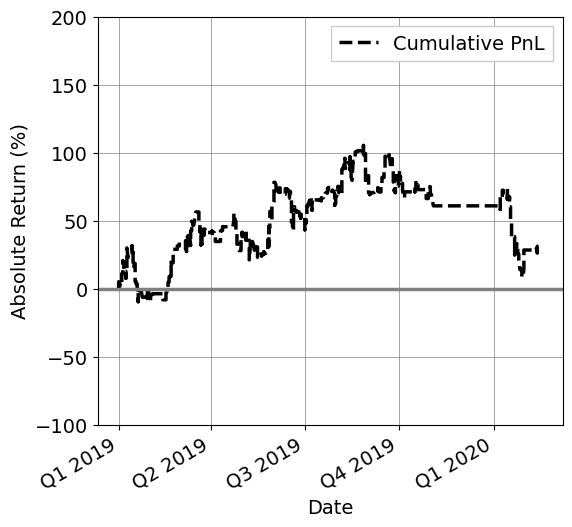

In [33]:
# Define the regressors
#regressors = ['inverse_avg', 'rankdist', 'wikibuzz', 'streak','wiki_trend_diff', 'elo_diff']
#regressors = ['inverse_avg', 'rankdist', 'wikibuzz']
#'wiki_trend_diff', 'elo_diff', 'set_diff', 'outcome','streak'
regressors = ['inverse_avg', 'rankdist', 'wikibuzz', 'avg_ratio', 'elo_diff', 'avg_margin', 'wiki_diff_yesterday_w', 'elo_ratio', 'elo_diff_squared', 'overround_avg']
#regressors = ['set_diff', 'avg_margin', 'wiki_trend_ratio_w', 'outcome', 'error']

#regressors = ['inverse_avg', 'rankdist', 'wikibuzz', 'avg_margin'] # its better !!!


#'wiki_trend_diff', 'elo_diff', 'set_diff', 'outcome','streak'

# Fit regression model
params = fit_regression(train_set=trainset, regressors=regressors)

# Evaluate results
testset_with_results = show_results(
    testset=testset,
    params=params,
    odds="avg",
    estimated_probabilities='model_est_prob',
    regressors=regressors
)

# Plot results
plot_results(testset_with_results)